# Expected Completion
Attempting to predict completion percentage.

## Libraries

In [203]:
import logging
import sys
import warnings

import numpy as np
import pandas as pd
from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    log_loss
)

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import (
    XGBClassifier,
    plot_importance
)

from pygam import (
    GAM,
    LogisticGAM,
    s,
    f,
    te
)

from yellowbrick.classifier import (
    ClassPredictionError,
    ClassificationReport,
    ROCAUC,
    PrecisionRecallCurve,
    DiscriminationThreshold
)

## Setup

In [4]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [228]:
# Pandas display
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

In [8]:
# BigQuery
PROJECT_ID = 'ad-big-data-bowl'
SERVICE_ACCOUNT_PATH = '../credentials/bigquery-admin.json'

In [234]:
SQL_BASE = \
"""
SELECT
  *,
  COS(qb_pass_direction - throw_direction) * qb_pass_speed AS qb_pass_velo_par,
  SIN(qb_pass_direction - throw_direction) * qb_pass_speed AS qb_pass_velo_orth
FROM
  (
    SELECT
      game_id,
      play_id,
      MAX(CASE WHEN position = 'QB' THEN nfl_id END) AS qb_nfl_id,
      MAX(CASE WHEN position = 'QB' THEN display_name END) AS qb_name,
      MAX(CASE WHEN targeted_receiver_flag = 1 THEN nfl_id END) AS receiver_nfl_id,
      MAX(CASE WHEN targeted_receiver_flag = 1 THEN display_name END) AS receiver_name,
      MAX(pass_complete_flag) AS pass_complete_flag,
      MAX(play_epa) AS play_epa,
      MAX(play_air_epa) AS play_air_epa,
      MAX(play_yac_epa) AS play_yac_epa,
      MAX(play_comp_air_epa) AS play_comp_air_epa,
      MAX(play_comp_yac_epa) AS play_comp_yac_epa,
      MAX(time_to_pass) AS time_to_pass,
      MAX(CASE WHEN position = 'QB' THEN pass_speed END) AS qb_pass_speed,
      MAX(CASE WHEN position = 'QB' THEN pass_direction END) AS qb_pass_direction,
      MAX(throw_direction) AS throw_direction,
      MAX(throw_distance) AS throw_distance,
      MAX(arrived_endline_distance) AS arrived_endline_distance,
      MAX(arrived_sideline_distance) AS arrived_sideline_distance,
      MAX(FLOOR(arrived_ball_x)) AS arrived_x,
      MAX(FLOOR(arrived_ball_y)) AS arrived_y,
      MIN(CASE WHEN player_side = 'defense' THEN pass_ball_distance END) AS closest_pass_rusher_distance,
      MIN(CASE WHEN player_side = 'defense' THEN arrived_ball_distance END) AS closest_pass_defender_distance,
      MIN(CASE WHEN player_side = 'defense' THEN arrived_pred_ball_distance END) AS closest_pred_pass_defender_distance,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 1 THEN 1 END), 0) AS pass_rushers_1yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 2 THEN 1 END), 0) AS pass_rushers_2yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 3 THEN 1 END), 0) AS pass_rushers_3yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 2 THEN 1 END), 0) AS pass_defenders_2yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 4 THEN 1 END), 0) AS pass_defenders_4yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 5 THEN 1 END), 0) AS pass_defenders_5yd
    FROM
      (
        SELECT
          *
        FROM
          `ad-big-data-bowl.workspace.passes_enhanced`
        WHERE
          personnel_offense_type = 'conventional'
            AND play_epa IS NOT NULL
      )
    GROUP BY 1, 2
  )
"""

In [235]:
# sql_base = SQL_BASE.format(**PARAMS)
sql_base = SQL_BASE

df_base = pd.read_gbq(query=sql_base, project_id=PROJECT_ID, dialect='standard',
                      private_key=SERVICE_ACCOUNT_PATH)

df_copy = df_base.copy()

  Elapsed 6.2 s. Waiting...
  Elapsed 7.44 s. Waiting...
  Elapsed 8.86 s. Waiting...
  Elapsed 10.09 s. Waiting...
  Elapsed 11.36 s. Waiting...
  Elapsed 12.75 s. Waiting...
  Elapsed 14.19 s. Waiting...
Total time taken 17.12 s.
Finished at 2019-01-13 20:26:21.


In [236]:
df_base.head()

,game_id,play_id,qb_nfl_id,qb_name,receiver_nfl_id,receiver_name,pass_complete_flag,play_epa,play_air_epa,play_yac_epa,play_comp_air_epa,play_comp_yac_epa,time_to_pass,qb_pass_speed,qb_pass_direction,throw_direction,throw_distance,arrived_endline_distance,arrived_sideline_distance,arrived_x,arrived_y,closest_pass_rusher_distance,closest_pass_defender_distance,closest_pred_pass_defender_distance,pass_rushers_1yd,pass_rushers_2yd,pass_rushers_3yd,pass_defenders_2yd,pass_defenders_4yd,pass_defenders_5yd,qb_pass_velo_par,qb_pass_velo_orth
0,2017101503,3840,2552588.000,Brett Hundley,1032,Jordy Nelson,1,0.663,0.645,0.018,0.645,0.018,2.500,0.950,293.700,318.980,23.110,58.650,6.050,61.000,47.000,2.630,4.310,1.780,0,0,1,0,0,1,0.940,-0.139
1,2017091009,264,2495425.000,Scott Tolzien,2532865,T.Y. Hilton,0,-6.107,3.040,-9.147,0.000,0.000,2.700,1.320,232.640,314.900,27.910,73.700,8.330,46.000,44.000,1.510,1.830,6.030,0,1,4,1,1,1,1.105,-0.722
2,2017091005,591,2543640.000,Tom Savage,2540165,DeAndre Hopkins,0,-0.934,1.598,-2.532,0.000,0.000,4.500,4.190,161.100,274.450,25.500,42.580,22.310,77.000,30.000,1.610,0.580,1.160,0,2,2,1,2,2,4.057,-1.047
3,2017101503,4246,2552588.000,Brett Hundley,1062,Martellus Bennett,1,0.548,0.436,0.112,0.436,0.112,2.700,0.720,126.450,250.860,15.160,42.560,23.900,77.000,23.000,3.110,5.550,3.670,0,0,0,0,0,0,0.224,0.684
4,2017091009,534,2495425.000,Scott Tolzien,2530660,Kamar Aiken,0,-2.247,1.776,-4.023,0.000,0.000,1.600,1.050,256.700,209.510,15.430,9.650,13.220,110.000,13.000,3.810,1.220,0.410,0,0,0,1,2,2,-1.048,-0.069


## Data preparation

In [237]:
# Base filters
_under_6s = df_base['time_to_pass'] < 6
_rusher_10y = df_base['closest_pass_rusher_distance'] < 10
_defender_30 = df_base['closest_pred_pass_defender_distance'] < 30
_inbounds_4 = df_base['arrived_sideline_distance'] > -4

df_pred = df_base[_under_6s & _rusher_10y & _defender_30 & _inbounds_4]

In [238]:
# Pred filters
_complete = df_pred['pass_complete_flag'] == 1
_incomplete = df_pred['pass_complete_flag'] == 0

## Plotting

In [78]:
key_features = [
    'time_to_pass',
    'qb_pass_speed',
    'qb_pass_velo_par',
    'qb_pass_velo_orth',
    'throw_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance',
    'closest_pass_rusher_distance',
    'closest_pass_defender_distance',
    'closest_pred_pass_defender_distance'
]

/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


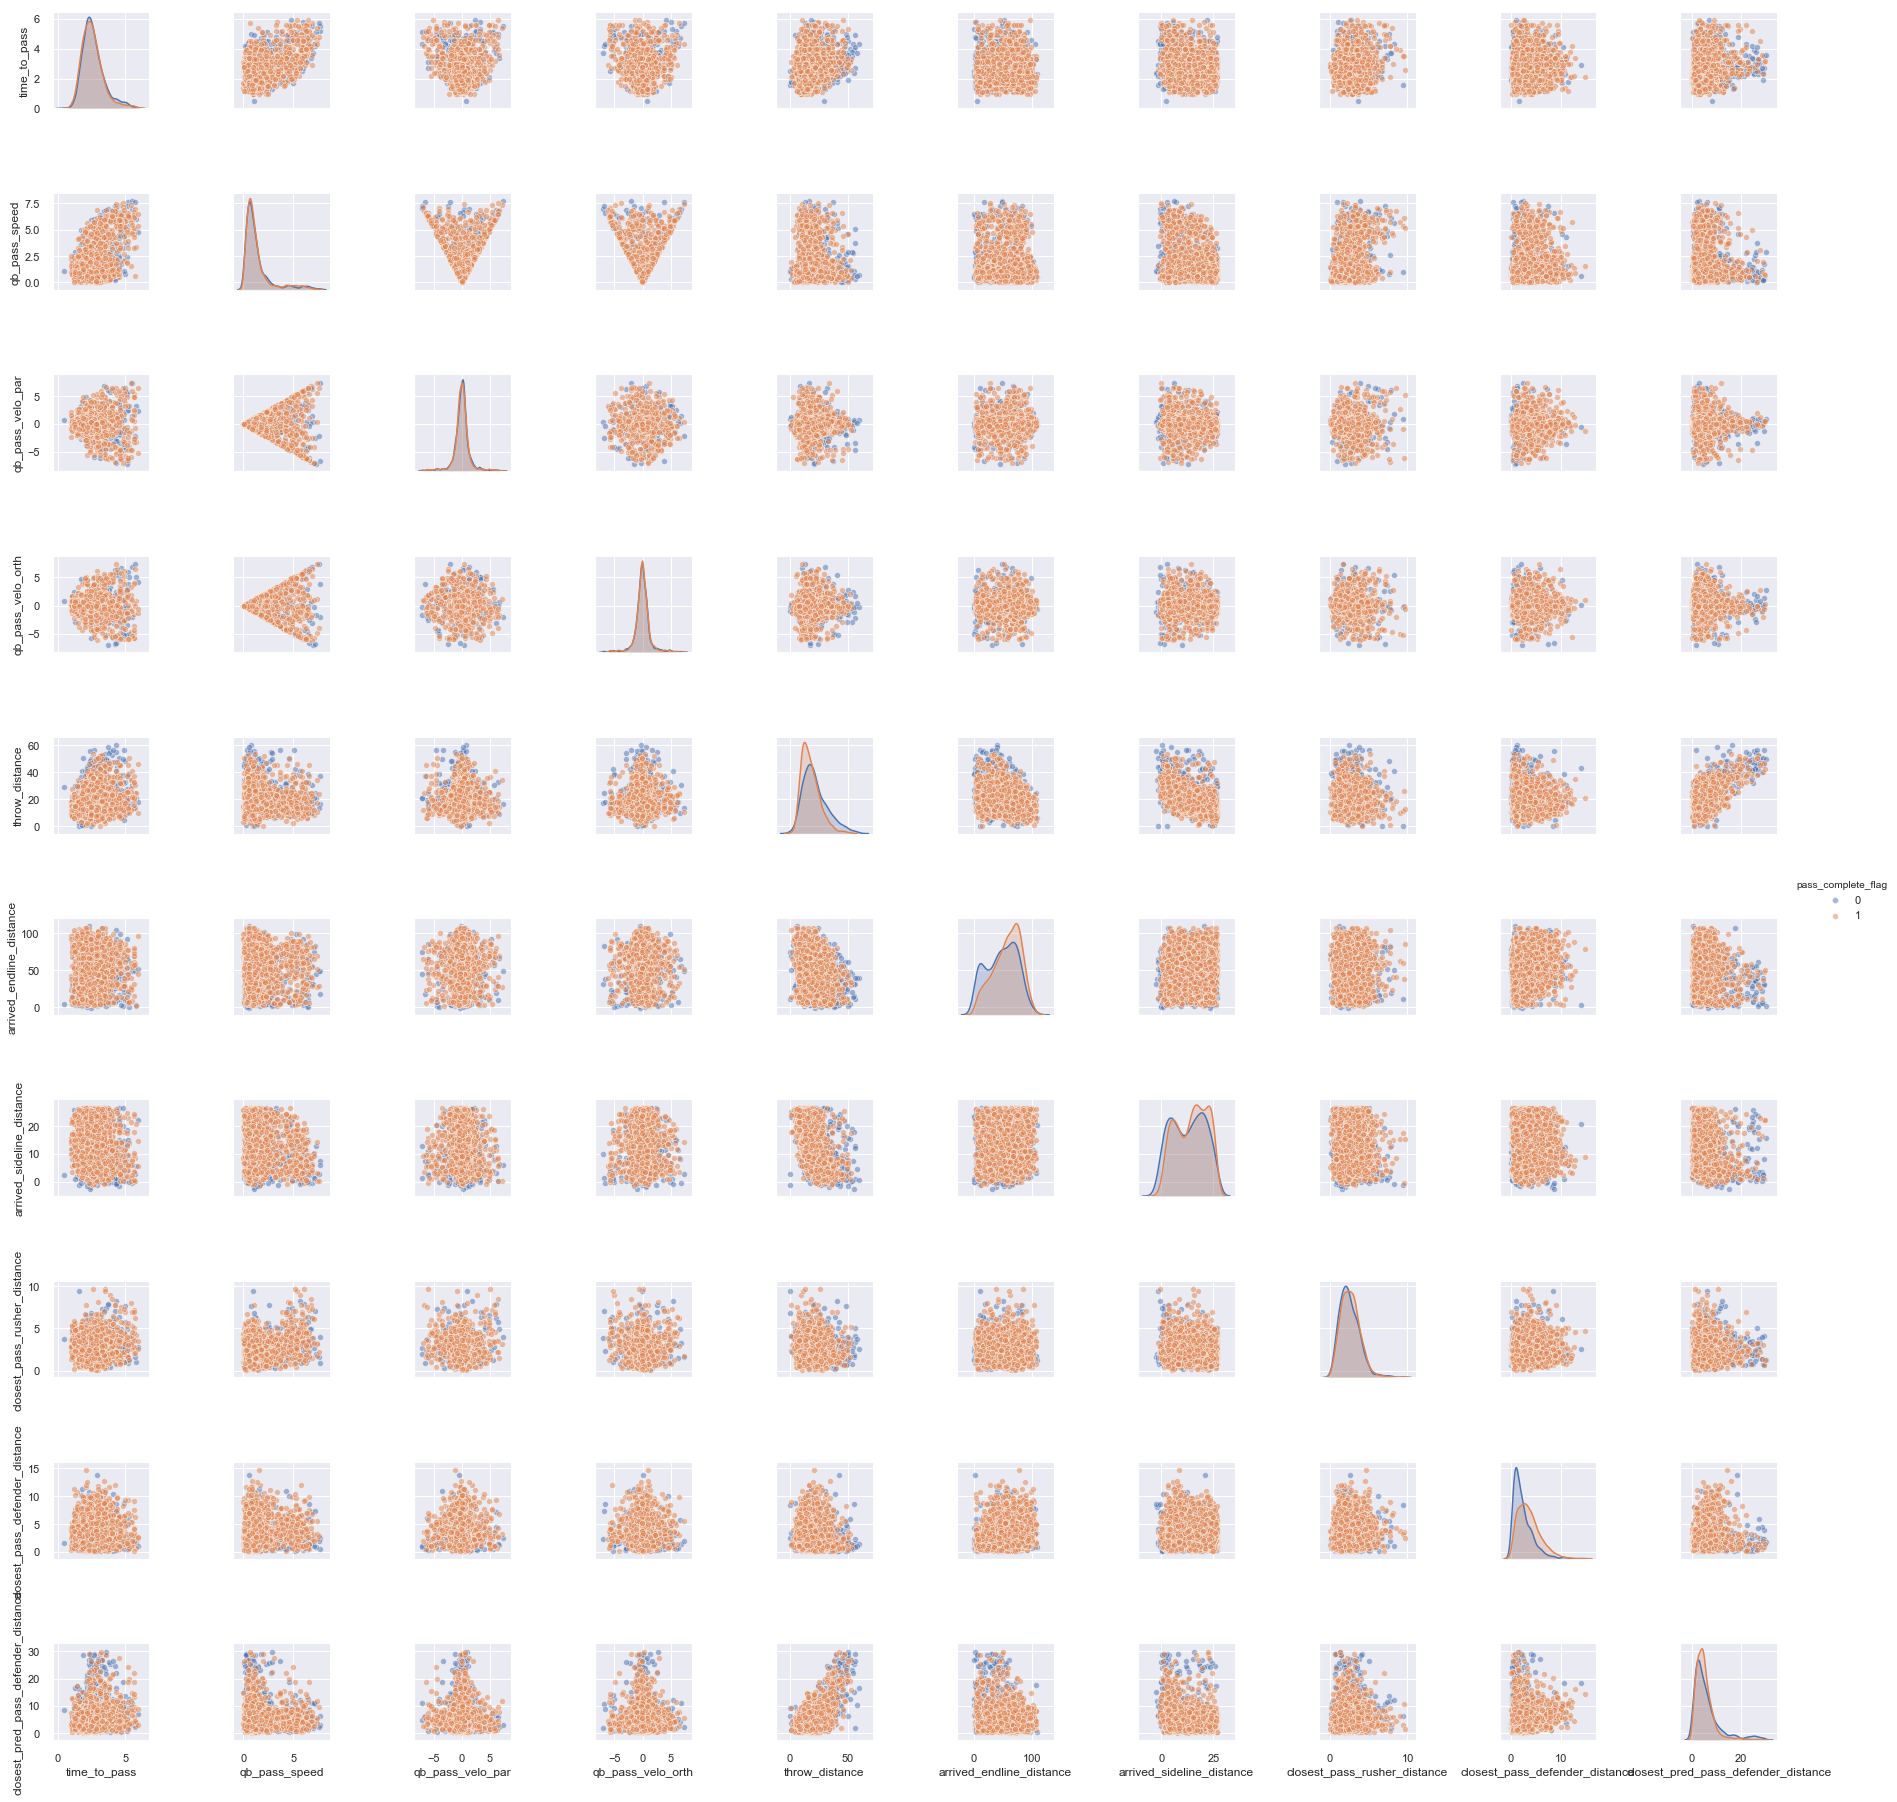

In [239]:
sns.pairplot(data=df_pred,
             vars=key_features,
             hue='pass_complete_flag',
             plot_kws={'alpha': 0.5})

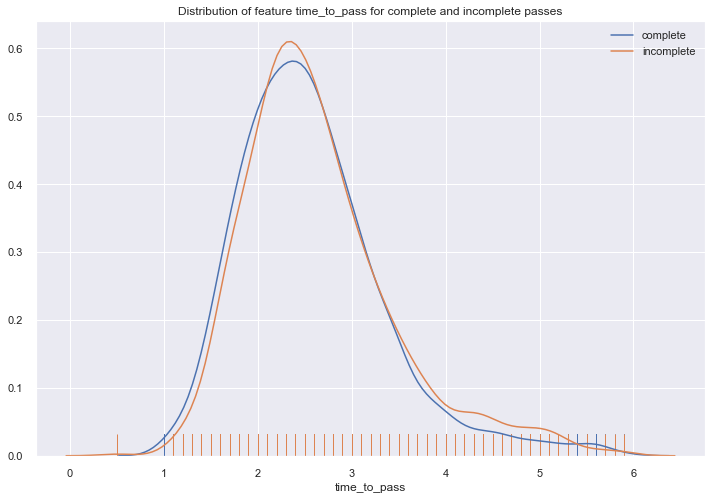

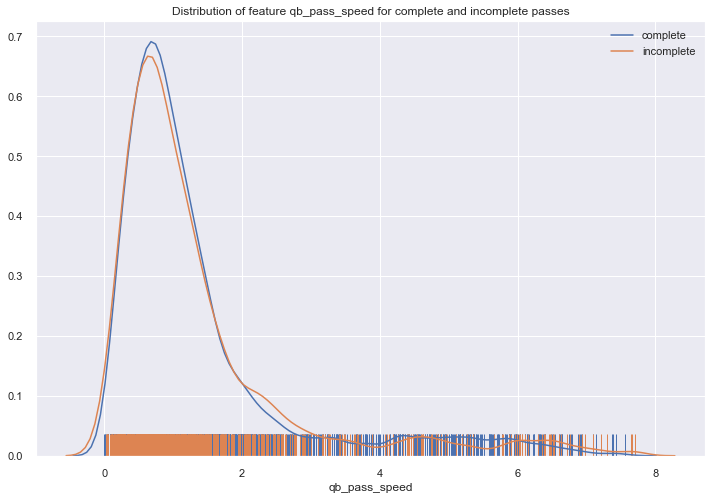

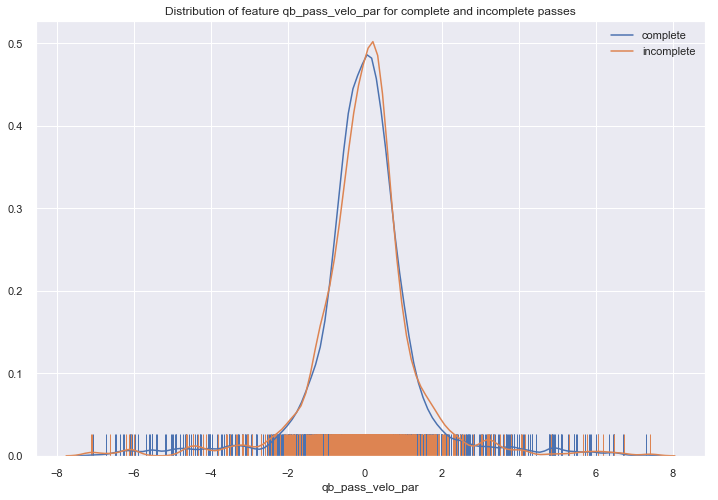

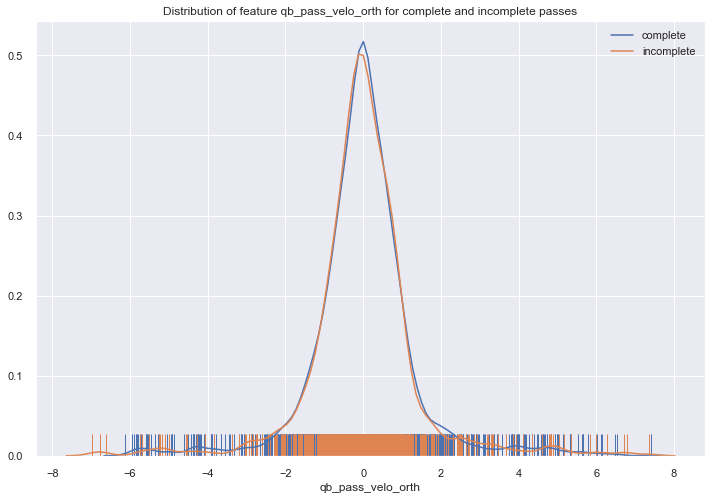

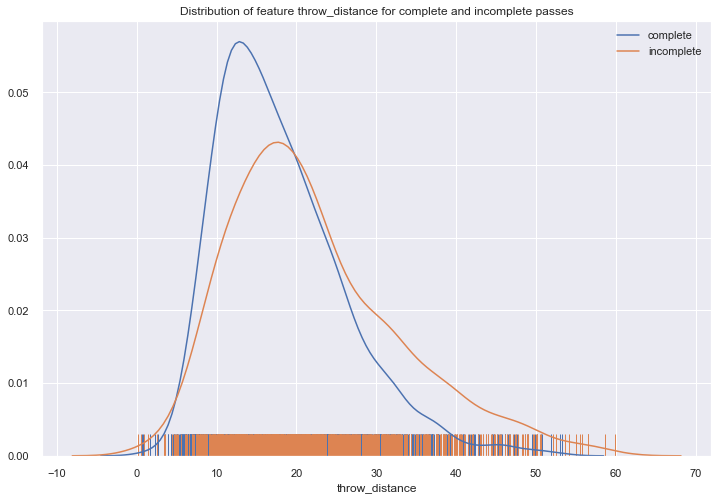

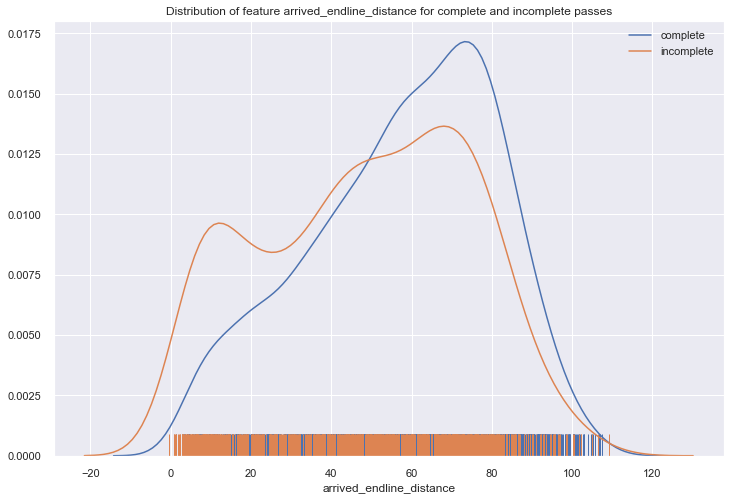

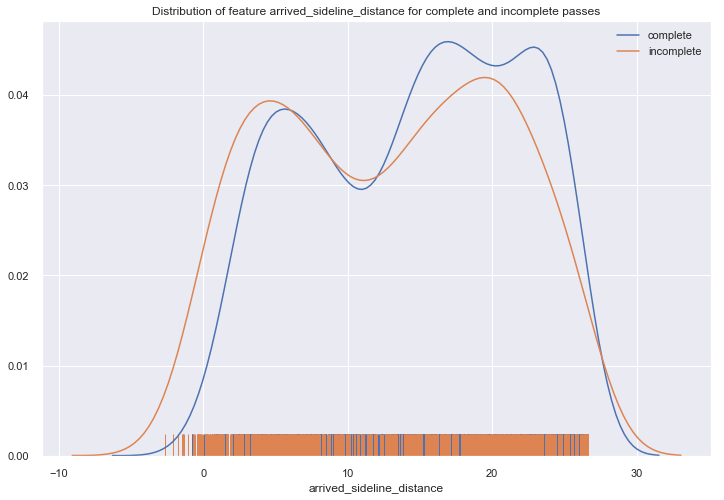

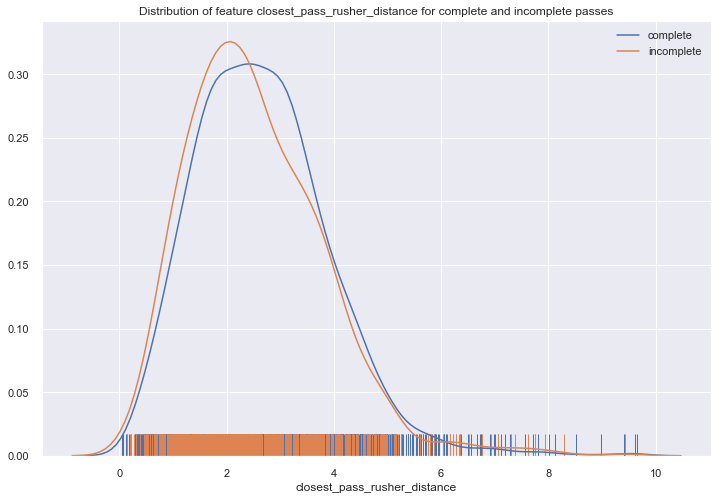

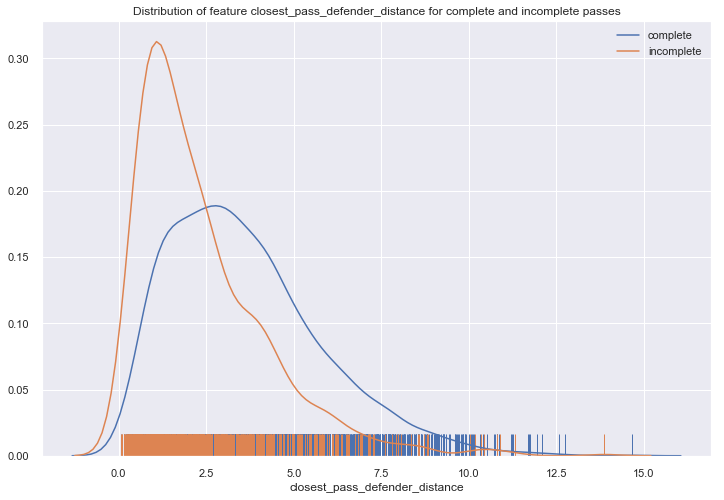

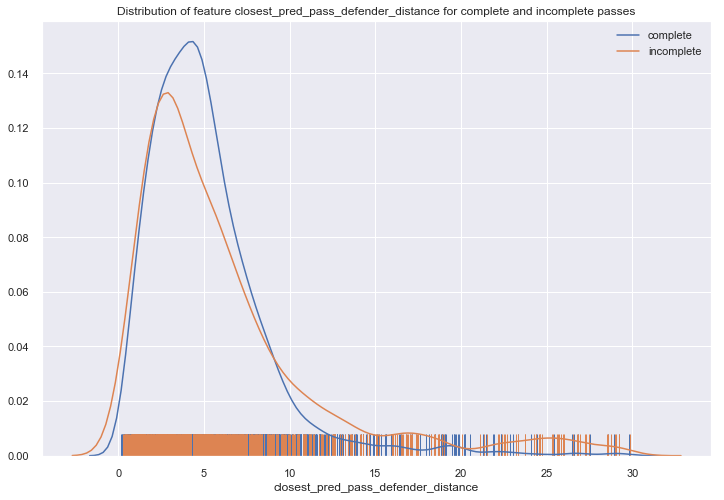

In [240]:
for feature in key_features:
    _comp_data = df_pred[_complete][feature]
    _inc_data = df_pred[_incomplete][feature]
    
    sns.distplot(a=_comp_data, label='complete', hist=False, rug=True)
    sns.distplot(a=_inc_data, label='incomplete', hist=False, rug=True)

    plt.title('Distribution of feature {:s} for complete and incomplete passes'.format(feature))
    plt.show()

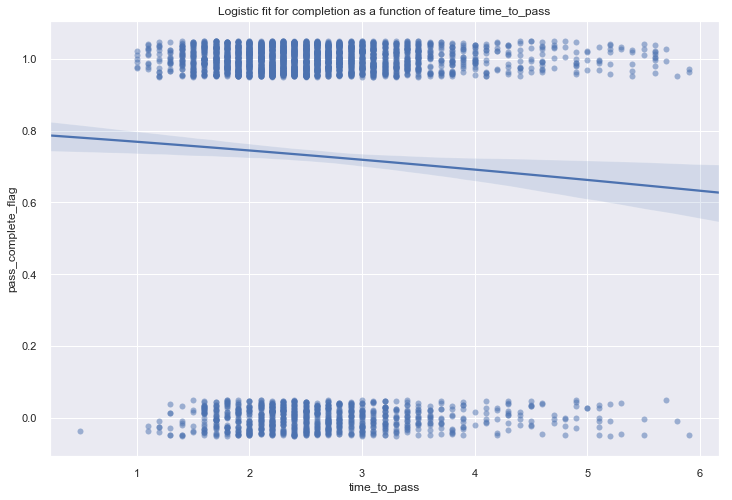

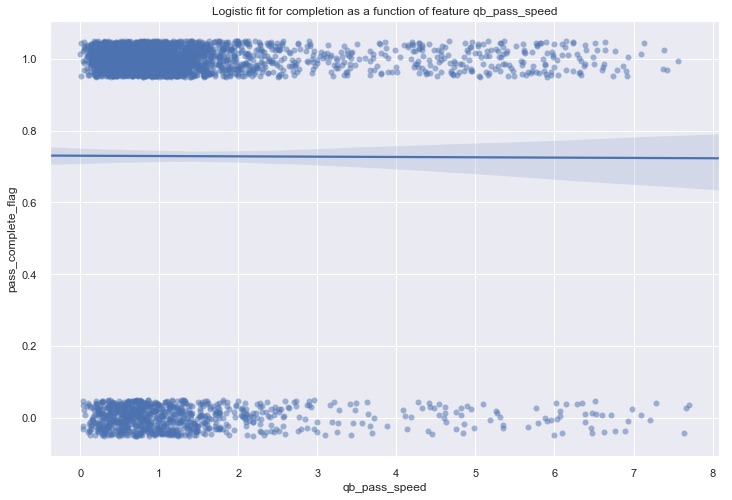

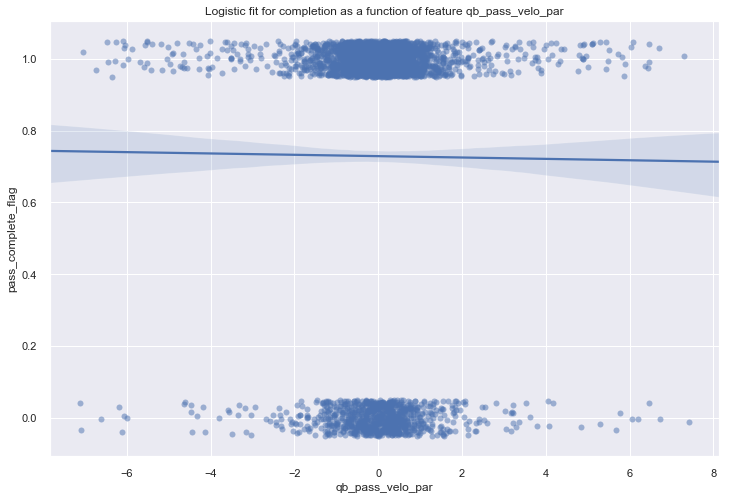

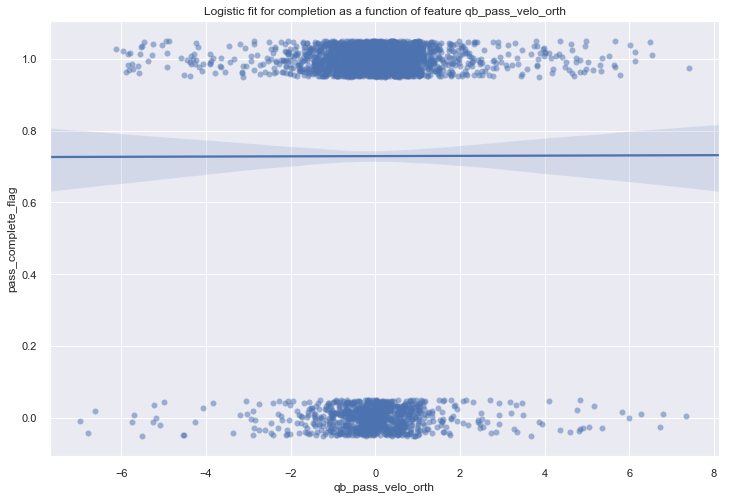

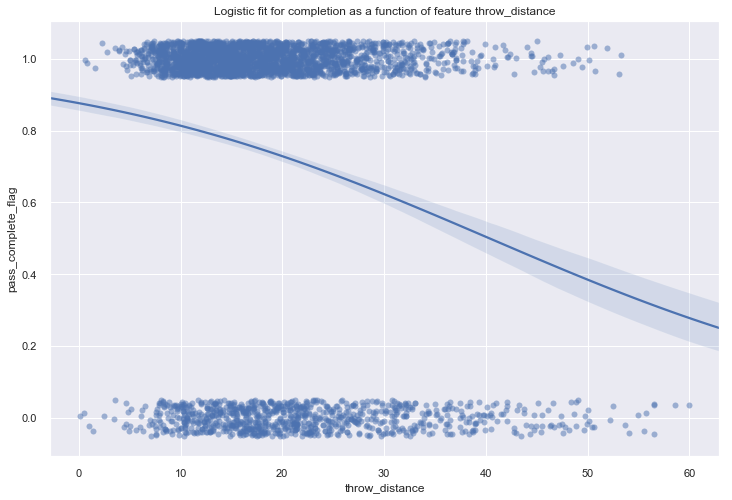

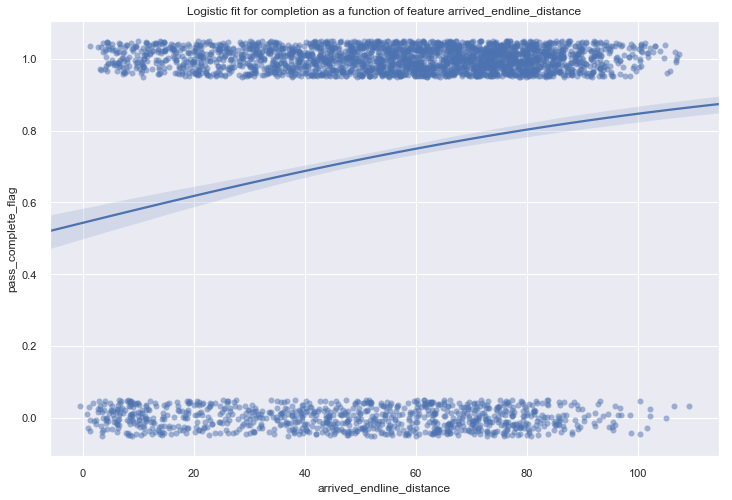

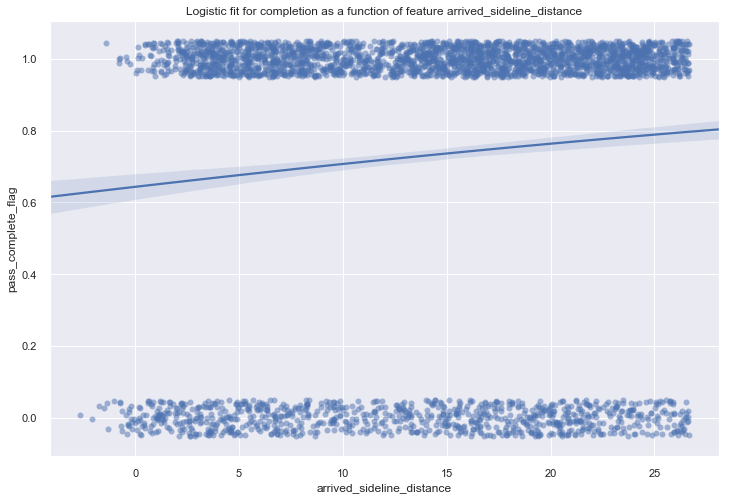

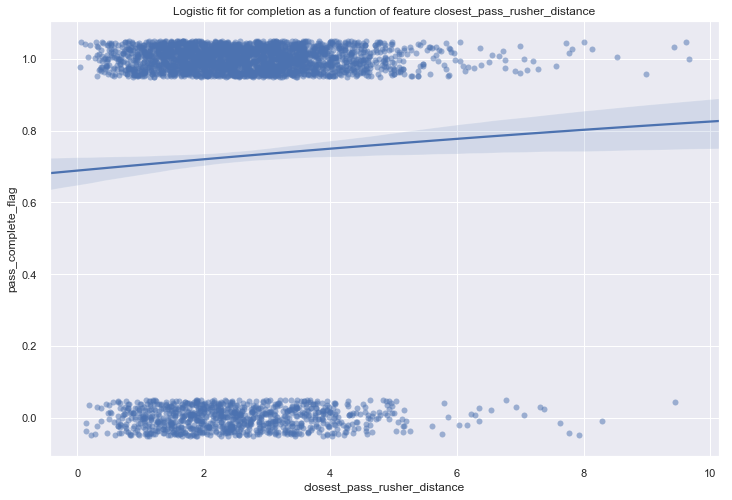

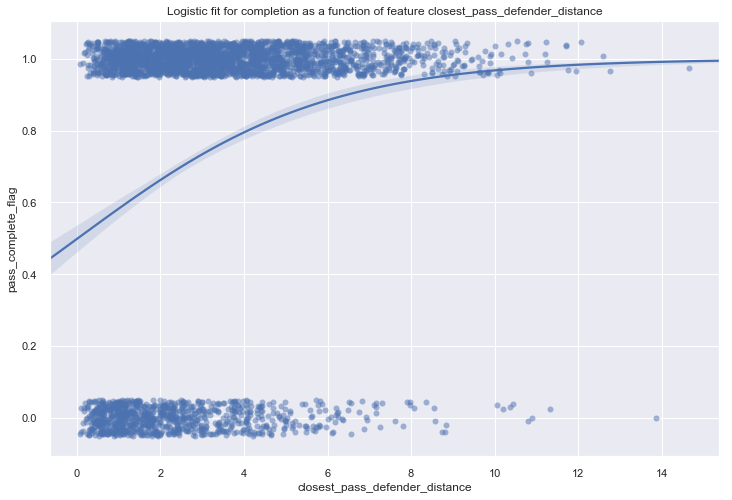

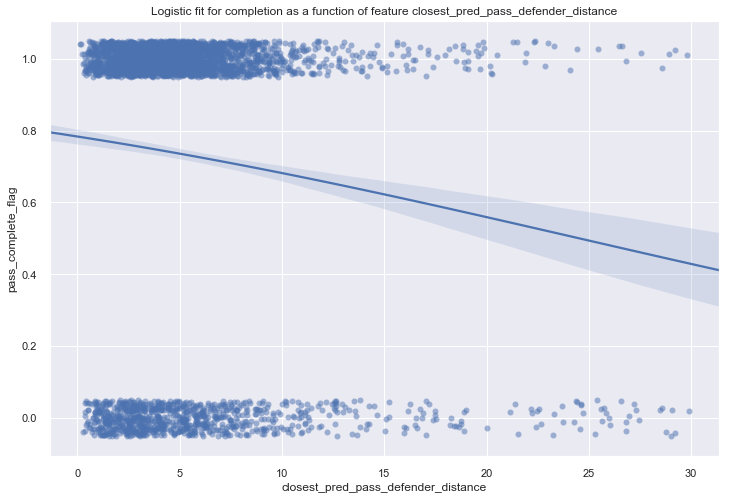

In [241]:
for feature in key_features:    
    sns.regplot(data=df_pred,
                x=feature,
                y='pass_complete_flag',
                logistic=True,
                y_jitter=0.05,
                scatter_kws={'alpha': 0.5})

    plt.title('Logistic fit for completion as a function of feature {:s}'.format(feature))
    plt.show()

## Modeling

### GAMs

In [175]:
def train_and_evaluate_gam(
        df,
        label,
        features,
        classes,
        model=None,
        constraints=None,
        lam=None,
        intercept=True,
        n_splines=10,
        resampler=None,
        test_size=0.2
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')

    # Handle None inputs
    if constraints is None:
        constraints = [None] * len(features)
        
    if lam is None:
        lam = np.logspace(-3, 3, 11)
    
    # Define X and y arrays
    X = _df[features].values
    y = _df[label].values
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1, stratify=y)
        
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
                
    # Train the model
    if model is None:
        model = LogisticGAM(n_splines=n_splines, fit_intercept=intercept)
    
    model.gridsearch(X_res,
                     y_res,
                     return_scores=True,
                     constraints=constraints,
                     lam=lam)

    num_terms = [ term for i, term in enumerate(model.terms) if not (term.istensor or term.isintercept) ]
    ten_terms = [ term for i, term in enumerate(model.terms) if term.istensor ]
    
    # Print GAM summary
    model.summary()
    
    # Plot individual features
    # Spline and factor terms
    plt.rcParams['figure.figsize'] = (28, 8)
    fig, axs = plt.subplots(1, len(num_terms))
    ax_idx = 0
        
    for i, term in enumerate(model.terms):
        if term.isintercept or term.istensor:
            continue
            
        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.9)

        ax = axs[ax_idx]
        ax_idx += 1

        ax.plot(XX[:, term.feature], pdep)
        ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_title(term.feature)

    plt.show()
    
    # Tensor terms
    plt.rcParams['figure.figsize'] = (12, 8)
    
    for i, term in enumerate(model.terms):
        if not term.istensor:
            continue

        XX = model.generate_X_grid(term=i, meshgrid=True)
        Z = model.partial_dependence(term=i, X=XX, meshgrid=True)

        ax = plt.axes(projection='3d')
        ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
        plt.show()

    # Test the model against the held over test set
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    # Model metrics
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nPrecision Score: {:3.3f}".format(precision_score(y_test, y_pred)))

    print("\nRecall Score: {:3.3f}".format(recall_score(y_test, y_pred)))

    print("\nF1 Score: {:3.3f}".format(f1_score(y_test, y_pred)))

    print("\nROC AUC Score: {:3.3f}".format(roc_auc_score(y_test, y_pred_proba)))

    print("\nAccuracy: {:3.3f}".format(accuracy_score(y_test, y_pred)))

    print("\nLog Loss: {:3.3f}".format(log_loss(y_test, y_pred_proba)))
    
    return model

In [242]:
gam_label_1 = 'pass_complete_flag'
gam_classes_1 = ['incomplete', 'complete']
gam_features_1 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance'
]
gam_constraints_1 = [None, 'monotonic_inc', None, None, None, None, None]
gam_lam_1 = np.logspace(1, 3, 7)
# gam_resampler_1 = SMOTE(random_state=42)
gam_model_1 = LogisticGAM(s(0, n_splines=10) +
                          s(1, n_splines=8, constraints='monotonic_inc') +
                          s(2, n_splines=8, constraints='monotonic_inc') +
                          s(3, n_splines=10) +
                          s(4, n_splines=8) +
                          s(5, n_splines=8))

completion_gam_1 = train_and_evaluate_gam(df=df_pred,
                                          label=gam_label_1,
                                          features=gam_features_1,
                                          classes=gam_classes_1,
                                          model=gam_model_1,
                                          lam=gam_lam_1,
                                          intercept=False,
                                          test_size=0.20,
                                          test_pred_threshold=0.7)

TypeError: train_and_evaluate_gam() got an unexpected keyword argument 'test_pred_threshold'

100% (30 of 30) |########################| Elapsed Time: 0:02:16 Time:  0:02:16


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     34.7322
Link Function:                        LogitLink Log Likelihood:                                 -1554.6106
Number of Samples:                         2907 AIC:                                             3178.6854
                                                AICc:                                               3179.6
                                                UBRE:                                                3.103
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0842
Feature Function                  Lam

/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



<Figure size 2016x576 with 0 Axes>

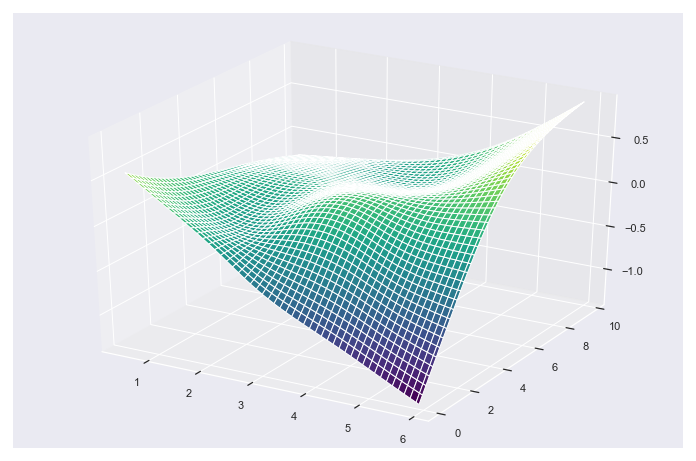

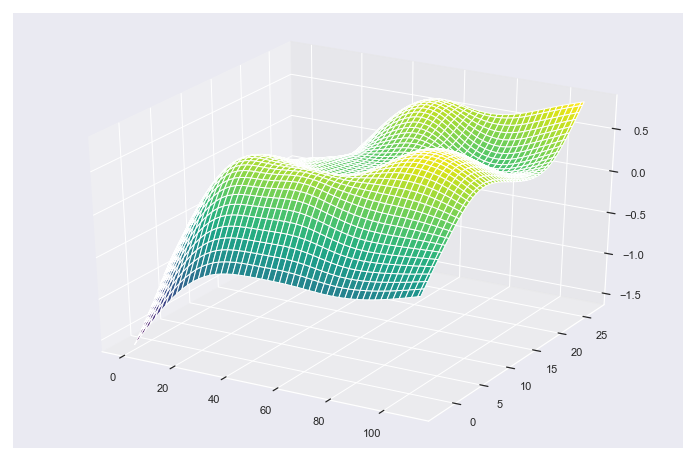

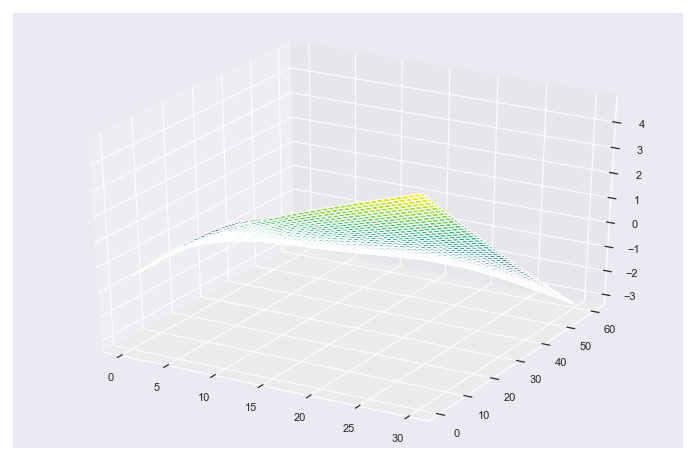


Confusion Matrix:
[[ 13 126]
 [ 11 363]]

Precision Score: 0.742

Recall Score: 0.971

F1 Score: 0.841

ROC AUC Score: 0.640

Accuracy: 0.733

Log Loss: 0.563


In [243]:
gam_label_2 = 'pass_complete_flag'
gam_classes_2 = ['incomplete', 'complete']
gam_features_2 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance'
]
gam_lam_2 = np.logspace(1, 3, 5)
# gam_resampler_2 = SMOTE(random_state=42)
gam_model_2 = LogisticGAM(te(0, 1, n_splines=15) +
                          te(2, 3, n_splines=20) +
                          te(4, 5, n_splines=15))

completion_gam_2 = train_and_evaluate_gam(df=df_pred,
                                          label=gam_label_2,
                                          features=gam_features_2,
                                          classes=gam_classes_2,
                                          model=gam_model_2,
                                          lam=gam_lam_2,
                                          intercept=True,
                                          test_size=0.15)

### XGBoost

In [244]:
def train_and_evaluate_classifier(
        df,
        label,
        features,
        classes,
        classifier,
        xgb_scale=None,
        scaler=None,
        resampler=None,
        test_size=0.20
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')
    
    y = _df[label]
    X = _df[features]
    
    # Preprocessing
    if scaler is not None:
        try:
            X = scaler.fit_transform(X)
        except:
            print("Error:", sys.exc_info()[0])
            raise
        
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    # Train the model
    classifier.fit(X_res, y_res)

    # Classifier description
    classifier_name = type(classifier).__name__
    if classifier_name in ['LogisticRegression']:
        print('COEFFICIENTS FOR {:s} CLASSIFIER'.format(classifier_name))
        
        intercept = classifier.intercept_
        if type(intercept) == np.ndarray:
            intercept = intercept[0]
        
        print("{:30}[{:5.3f}]".format('Intercept:', intercept))

        for feature, weight in list(zip(features, classifier.coef_[0])):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
        
    if classifier_name in ['XGBClassifier']:
        plot_importance(classifier)
        plt.show()
        
    # Class prediction error plot
    cpe_plot = ClassPredictionError(classifier, classes=classes)
    cpe_plot.fit(X_train, y_train)
    cpe_plot.score(X_test, y_test)
    cpe_plot.poof()
    
    # Classification report
    cr_plot = ClassificationReport(classifier, classes=classes, support=True)
    cr_plot.fit(X_train, y_train)
    cr_plot.score(X_test, y_test)
    cr_plot.poof()
    
    # ROC/AUC plot
    rocauc_plot = ROCAUC(classifier, classes=classes)
    rocauc_plot.fit(X_train, y_train)
    rocauc_plot.score(X_test, y_test)
    rocauc_plot.poof()
    
    # Precision recall plot
    pr_plot = PrecisionRecallCurve(classifier)
    pr_plot.fit(X_train, y_train)
    pr_plot.score(X_test, y_test)
    pr_plot.poof()
        
    # Discrimination Threshold
    dt_plot = DiscriminationThreshold(classifier)
    dt_plot.fit(X_train, y_train)
    dt_plot.poof()
        
    return classifier

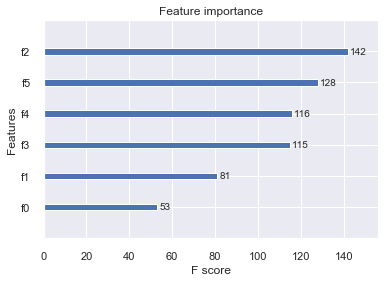

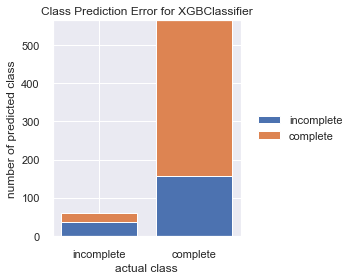

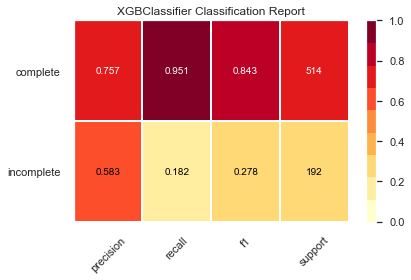

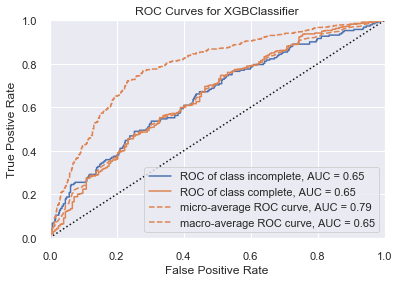

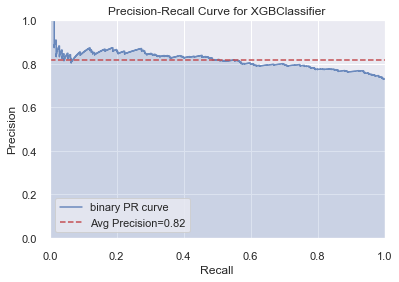

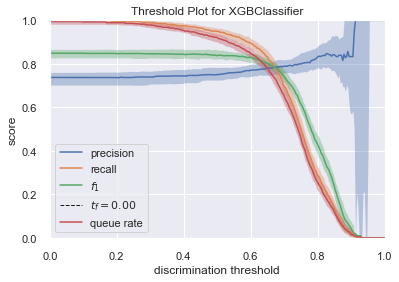

In [222]:
xgb_label_1 = 'pass_complete_flag'
xgb_classes_1 = ['incomplete', 'complete']
xgb_features_1 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance'
]

xgb_model_1 = XGBClassifier(scale_pos_weight=0.9)
xgb_scaler_1 = MaxAbsScaler()
# xgb_resampler_1 = RandomUnderSampler(random_state=42)

completion_xgb_1 = train_and_evaluate_classifier(df=df_pred,
                                                 label=xgb_label_1,
                                                 features=xgb_features_1,
                                                 classes=xgb_classes_1,
                                                 classifier=xgb_model_1,
                                                 scaler=xgb_scaler_1,
                                                 test_size=0.20)

## Model application

In [245]:
def apply_model(
        df,
        model,
        features,
        label,
        agg_column,
        count_column,
        scaler=None
    ):
    
    # Get useful features
    output = df.copy()
    output = output.dropna(axis=0, how='any')        
        
    X = output[features]
    if scaler is not None:
        X = scaler.transform(X)
    
    pred_col = '{:s}_pred'.format(label)
    prob_col = '{:s}_prob'.format(label)
    
    # Generate predictions
    probs = model.predict_proba(X)
    if probs.ndim > 1:
        probs = np.asarray([ p[1] for p in probs ])
    
    output[pred_col] = model.predict(X)
    output[prob_col] = probs
        
    # Summarize results
    output_agg = output.groupby(agg_column).agg({
        label: 'mean',
        prob_col: 'mean',
        count_column: 'count'
    })
    
    output_agg = output_agg.rename(columns={
        count_column: 'count'
    })
    
    delta_col = '{:s}_delta'.format(label)
    output_agg[delta_col] = output_agg[label] - output_agg[prob_col]
    
    return output, output_agg

In [250]:
gam_qb, gam_qb_agg = apply_model(df=df_pred,
                                 model=completion_gam_2,
                                 features=gam_features_2,
                                 label=gam_label_2,
                                 agg_column='qb_name',
                                 count_column='play_id')

gam_qb_agg = gam_qb_agg[gam_qb_agg['count'] > 50]
gam_qb_agg = gam_qb_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'attempts',
    'pass_complete_flag_delta': 'completion_pct_delta'
})

gam_qb_agg.sort_values(by='exp_completion_pct', ascending=False).head(50)

,completion_pct,exp_completion_pct,attempts,completion_pct_delta
qb_name,,,,
Matt Ryan,0.756,0.775,90,-0.019
DeShone Kizer,0.659,0.761,88,-0.102
Dak Prescott,0.847,0.759,72,0.088
Tyrod Taylor,0.691,0.755,68,-0.064
Joe Flacco,0.660,0.754,106,-0.094
Eli Manning,0.707,0.752,133,-0.046
Alex Smith,0.804,0.750,102,0.054
Kirk Cousins,0.763,0.747,93,0.016
Jay Cutler,0.646,0.742,99,-0.095


In [247]:
gam_wr, gam_wr_agg = apply_model(df=df_pred,
                                 model=completion_gam_2,
                                 features=gam_features_2,
                                 label=gam_label_2,
                                 agg_column='receiver_name',
                                 count_column='play_id')

gam_wr_agg = gam_wr_agg[gam_wr_agg['count'] > 15]
gam_wr_agg = gam_wr_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'targets',
    'pass_complete_flag_delta': 'completion_pct_delta'
})


gam_wr_agg.sort_values(by='exp_completion_pct', ascending=True).head(50)

,completion_pct,exp_completion_pct,targets,completion_pct_delta
receiver_name,,,,
Paul Richardson,0.688,0.623,16,0.064
John Brown,0.647,0.634,17,0.013
Stefon Diggs,0.882,0.634,17,0.248
Donte Moncrief,0.722,0.635,18,0.088
Tyler Lockett,0.706,0.653,17,0.053
Hunter Henry,0.824,0.656,17,0.168
Marvin Jones,0.600,0.660,20,-0.060
Robby Anderson,0.478,0.666,23,-0.188
J.J. Nelson,0.824,0.668,17,0.155


In [248]:
xgb_qb, xgb_qb_agg = apply_model(df=df_pred,
                                 model=completion_xgb_1,
                                 features=xgb_features_1,
                                 label=xgb_label_1,
                                 agg_column='qb_name',
                                 count_column='play_id',
                                 scaler=xgb_scaler_1)

xgb_qb_agg = xgb_qb_agg[xgb_qb_agg['count'] > 50]
xgb_qb_agg = xgb_qb_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'attempts',
    'pass_complete_flag_delta': 'completion_pct_delta'
})

xgb_qb_agg.sort_values(by='completion_pct_delta', ascending=False).head(50)

,completion_pct,exp_completion_pct,attempts,completion_pct_delta
qb_name,,,,
Dak Prescott,0.847,0.588,72,0.259
Alex Smith,0.804,0.570,102,0.234
Josh McCown,0.790,0.557,105,0.233
Philip Rivers,0.785,0.554,121,0.231
Case Keenum,0.768,0.545,82,0.223
Andy Dalton,0.735,0.512,83,0.223
Marcus Mariota,0.795,0.576,78,0.219
Carson Wentz,0.777,0.571,112,0.206
Derek Carr,0.756,0.555,82,0.201
